- 순환 드롭아웃: 순환 층에서 과대적합을 방지하기 위해 케라스에 내장되어 있는 드롭아웃을 사용합니다.
- 스태킹 순환 층: 네트워크의 표현 능력을 증가시킵니다.
- 양방향 순환 층: 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지시킵니다.

# 1. 기온 예측 문제

## 1. 데이터 준비

In [1]:
import os

data_dir = './datasets/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

In [2]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


### 데이터 파싱하기

In [3]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

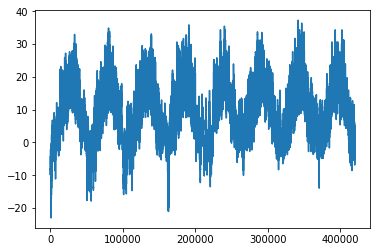

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)

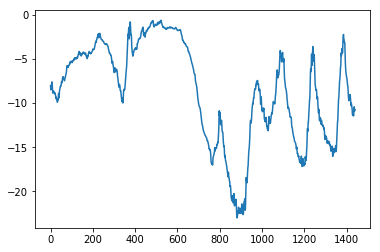

In [10]:
plt.plot(range(1440), temp[:1440])

## 2. 데이터 전처리

이 문제의 정확한 정의는 다음과 같습니다. lookback 타임스템만큼 이전으로 돌아가서 매 steps 타임스텝마다 샘플링합니다. 이 데이터를 바탕으로 delay 타임스텝 이후의 온도를 예측합니다.

1) lookback = 1440: 10일 전 데이터로 돌아갑니다.

2) steps = 6:1시간마다 데이터 푄트를 하나를 샘플링합니다.

3) delay = 144:24시간 지난 데이터가 타깃이 됩니다.

- 시작하기 전에 두 가지 작업을 처리해야 합니다.

1) 신경망에 주입할 수 있는 형태로 데이터를 전처리합니다. 각 시계열 특성을 개별적으로 정규화하여 비슷한 범위를 가진 작은 값으로 바꾸겠습니다.

2) float_data 배열을 받아 과거 데이터 배치와 미래 타깃 온도를 추출하는 generator를 만듭니다. 이 데이터셋에 있는 샘플은 중복이 많습니다. 모든 샘플은 각기 메모리에 적재하는 것은 낭비가 심하므로 대신에 원본 데이터를 사용하여 그때 그때 배치를 만들겠습니다.

In [11]:
# Standardization
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

## 3. Generator 생성

In [18]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    """
    data: data
    lookback: 입력으로 사용하기 위해 거슬러 올라갈 타임스텝
    delay: 타깃으로 사용할 미래의 타임스텝
    min_index와 max_index: 추출할 타임스텝 범위를 지정하기 위한 data 배열의 인덱스, 검증 데이터와 테스트 데이터를 분리하는 데 사용합니다.
    shuffle: 샘플을 섞을지, 시간 순서대로 추출할 지 결정한다
    batch_size: 배치 샘플 수
    step: 데이터를 샘플링할 타임스텝 간격, 1시간에 하나의 데이터 포인트 추출을 위해 6으로 지정한다.
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size
            )
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            
            # batch_size 만큼 뽑는다.
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        # empty
        samples = np.zeros((len(rows),
                            lookback//step,
                            data.shape[-1]))
        targets = np.zeros((len(rows), ))
        
        for j, row in enumerate(rows):
            # step 간격으로 추출
            indices = range(rows[j] - lookback, rows[j], step)
            
            # sample (128, 240, 14)
            samples[j] = data[indices]
            
            # target (128,)
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [19]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [20]:
train_gen = generator(float_data, 
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data, 
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step, 
                    batch_size=batch_size)

test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

In [21]:
print(val_steps, test_steps)

769 930


## 4.상식 수준의 기준점

- 24시간 후 온도가 현재 온도와 동일하다고 예측한다.

In [23]:
def evaluate_naive_method():
    batch_maes = []
    
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))
    
evaluate_naive_method()

0.2897359729905486


In [25]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

- 섭시 2.57도 차이

## 5. 기본적인 머신러닝 방법

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20, 
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 7s 14ms/step - loss: 1.3503 - val_loss: 0.7278
Epoch 2/20
500/500 [==============================] - 7s 14ms/step - loss: 0.4156 - val_loss: 0.3191
Epoch 3/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2883 - val_loss: 0.3166
Epoch 4/20
500/500 [==============================] - 7s 13ms/step - loss: 0.2654 - val_loss: 0.3163
Epoch 5/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2517 - val_loss: 0.3225
Epoch 6/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2429 - val_loss: 0.3448
Epoch 7/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2382 - val_loss: 0.3178
Epoch 8/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2319 - val_loss: 0.3214
Epoch 9/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2264 - val_loss: 0.3223
Epoch 10/20
500/500 [==============================] - 7s 14ms/step - loss: 0.2216 - val_lo

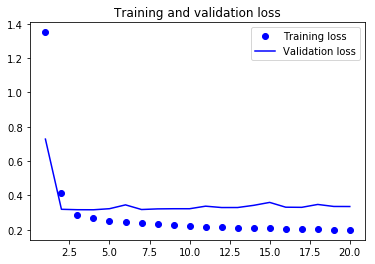

In [28]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()

## 6. 첫번째 순환 신경망

In [30]:
# psuedocode for GRU

# output_t = z_t * state_t + (1 - z_t) * g_t
# state_(t+1) = output_t

# z_t = sigmoid(dot(state_t, Uz) + dot(input_t, Wz) + bz) - control
# r_t = sigmoid(dot(state_t, Ur) + dot(input_t, Wr) + br) - input 중 어느 부분을 출력할 지 결정
# g_t = tanh(r_t * state_t, Ug) + dot(input_t, Wg) + bg) - input

In [29]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20, 
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 44s 89ms/step - loss: 0.3064 - val_loss: 0.2692
Epoch 2/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2848 - val_loss: 0.2672
Epoch 3/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2790 - val_loss: 0.2623
Epoch 4/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2737 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2723 - val_loss: 0.2643
Epoch 6/20
500/500 [==============================] - 43s 86ms/step - loss: 0.2682 - val_loss: 0.2624
Epoch 7/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2642 - val_loss: 0.2617
Epoch 8/20
500/500 [==============================] - 43s 87ms/step - loss: 0.2596 - val_loss: 0.2684
Epoch 9/20
500/500 [==============================] - 44s 87ms/step - loss: 0.2545 - val_loss: 0.2638
Epoch 10/20
500/500 [==============================] - 43s 87ms/step - loss: 0.251

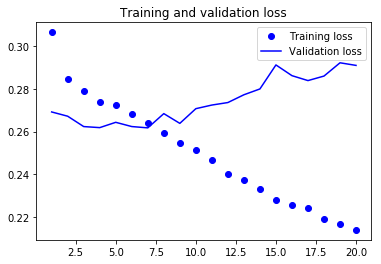

In [31]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [32]:
celsius_mae = 0.265 * std[1]
celsius_mae

2.3459122567842243

- 기존 Baseline보다 성능이 개선되었다.

- 과적합이다. 따라서 드롭아웃을 사용한다. 몇 번의 에포크 이후에 훈련 손실과 검증 손실이 현저하게 벌어진다.

## 7. 순환 드롭아웃 사용하기

- 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 신경망에 드롭아웃을 올바르게 적용하는 방법은 간단하지 않습니다. 순환 층 이전에 드롭아웃을 적용하면 규제에 도움이 되는 것보다 학습에 더 방해가 되는 것으로 오랫동안 알려졌습니다.

- 순환 신경망에서는 타임스텝마다 랜덤하게 드롭아웃 마스크를 바꾸는 것이 아니라 동일한 드롭아웃 마스크를 모든 타임스텝에 적용해야 합니다. GRU와 LSTM 같은 순환 게이트에 의해 만들어진 표현을 규제하려면 순환 층 내부 연산에 사용된 활성회 함수의 타임스텝마다 동일한 드롭아웃 마스크를 적용해야 합니다.

- 모든 타임스텝에 동일한 드롭아웃 마스크를 사용하면 네트워크가 학습 오차를 타임스텝에 걸쳐 적절하게 전파시킬 것입니다. 타임스텝마다 랜덤한 드롭아웃 마스크를 적용하면 오차 신호가 전파되는 것을 방해하고 학습 과정에 해를 끼칩니다.

In [34]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
    
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20, 
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 48s 97ms/step - loss: 0.3544 - val_loss: 0.2773
Epoch 2/20
500/500 [==============================] - 48s 96ms/step - loss: 0.3176 - val_loss: 0.2733
Epoch 3/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3106 - val_loss: 0.2656
Epoch 4/20
500/500 [==============================] - 48s 97ms/step - loss: 0.3036 - val_loss: 0.2648
Epoch 5/20
500/500 [==============================] - 49s 98ms/step - loss: 0.3003 - val_loss: 0.2738
Epoch 6/20
500/500 [==============================] - 48s 97ms/step - loss: 0.2987 - val_loss: 0.2663
Epoch 7/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2962 - val_loss: 0.2647
Epoch 8/20
500/500 [==============================] - 49s 98ms/step - loss: 0.2947 - val_loss: 0.2648
Epoch 9/20
500/500 [==============================] - 48s 96ms/step - loss: 0.2922 - val_loss: 0.2661
Epoch 10/20
500/500 [==============================] - 48s 96ms/step - loss: 0.290

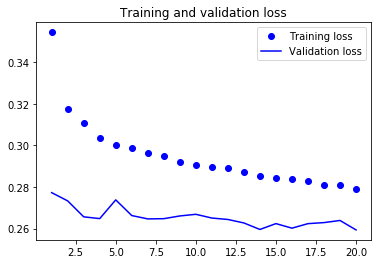

In [35]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()

- LSTM에는 input_t에 dropout 비율이 적용되고 state_t에 recurrent_dropout 비율이 적용된다. 주의할 점은 코드 6-25에 사용되는 4개의 input_t에 각기 다른 드롭아웃 마스크가 적용된다는 점이다. 마찬가지로 4개의 state_t에도 다른 드롭아웃 마스크가 적용된다.


- 과대적합은 없지만 성능상 병목이 있는 것 같으므로 네트워크 용량을 늘려본다. 너무 많이 과대적합되지 않는 한 충분한 용량에 도달한 것이 아니다. 네트워크 용량을 늘리려면 일반적으로 층에 있는 유닛의 수를 늘리거나 층을 더 많이 추가한다.


- 순환 스태킹은 더 강력한 순환 네트워크를 만드는 고전적인 방법이다. 구글 번역기는 현재 7개의 대규모 LSTM 층을 쌓은 모델에서 나온 것이다.

## 8. 스태킹 순환층

In [41]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.1,
                    recurrent_dropout=0.5,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64,
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 117s 235ms/step - loss: 0.3398 - val_loss: 0.2766
Epoch 2/40
500/500 [==============================] - 117s 233ms/step - loss: 0.3170 - val_loss: 0.2775
Epoch 3/40
500/500 [==============================] - 117s 234ms/step - loss: 0.3077 - val_loss: 0.2830
Epoch 4/40
500/500 [==============================] - 117s 233ms/step - loss: 0.3044 - val_loss: 0.2736
Epoch 5/40
500/500 [==============================] - 117s 234ms/step - loss: 0.3001 - val_loss: 0.2691
Epoch 6/40
500/500 [==============================] - 117s 234ms/step - loss: 0.2949 - val_loss: 0.2687
Epoch 7/40
500/500 [==============================] - 116s 232ms/step - loss: 0.2937 - val_loss: 0.2721
Epoch 8/40
500/500 [==============================] - 116s 232ms/step - loss: 0.2913 - val_loss: 0.2716
Epoch 9/40
500/500 [==============================] - 117s 233ms/step - loss: 0.2872 - val_loss: 0.2657
Epoch 10/40
500/500 [==============================] - 116s 233m

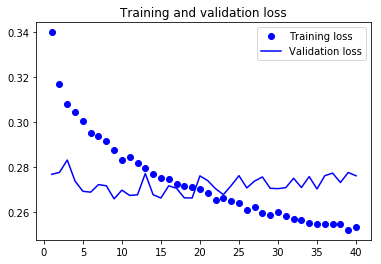

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()
plt.show()